# Dimensionality Reduction via t-SNE

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 5, Tutorial (this is discussed in session 5)

See https://machine-learning-for-physicists.org and the current course website linked there!



The following python code for t-SNE is an original code by the inventor of t-SNE, Laurens van der Maaten. It is available on his website https://lvdmaaten.github.io/tsne/ . 

It is stated on that website: "*You are free to use, modify, or redistribute this software in any way you want, but only for non-commercial purposes. The use of the software is at your own risk; the authors are not responsible for any damage as a result from errors in the software.*"

In [83]:
import numpy as np

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=90 # highres display

# for updating display 
# (very simple animation)
from IPython.display import clear_output

In [84]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

# note by FM: For this notebook, the MNIST example was dropped

import numpy as np

def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0, 
         do_animation=False, animation_skip_steps=10, max_iter = 1000):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
        
        Added by F. Marquardt: do_animation==True will give you a graphical animation of
        the progress, use animation_skip_steps to control how often this will
        be plotted; max_iter controls the total number of gradient descent steps
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    if do_animation: # added by FM
        costs=np.zeros(max_iter) # to store the cost values
        
    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        if not do_animation: # added by FM: do not print if we are animating!
            # Compute current value of cost function
            if (iter + 1) % 10 == 0:
                C = np.sum(P * np.log(P / Q))
                print("Iteration %d: error is %f" % (iter + 1, C), end="           \r") # modified to overwrite line

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.
            
        if do_animation:  # added by FM
            C = np.sum(P * np.log(P / Q)) # compute for every step, to store it in 'costs'
            costs[iter]=C
            if iter % animation_skip_steps==0:
                clear_output(wait=True)
                fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(10,5))
                ax[0].plot(costs)
                ax[1].scatter(Y[:,0],Y[:,1],color="orange")
                plt.show()

    # Return solution
    return Y


# if __name__ == "__main__":
#     print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
#     print("Running example on 2,500 MNIST digits...")
#     X = np.loadtxt("mnist2500_X.txt")
#     labels = np.loadtxt("mnist2500_labels.txt")
#     Y = tsne(X, 2, 50, 20.0)
#     pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
#     pylab.show()


# Example 1: A few Gaussian clouds in high-dimensional space

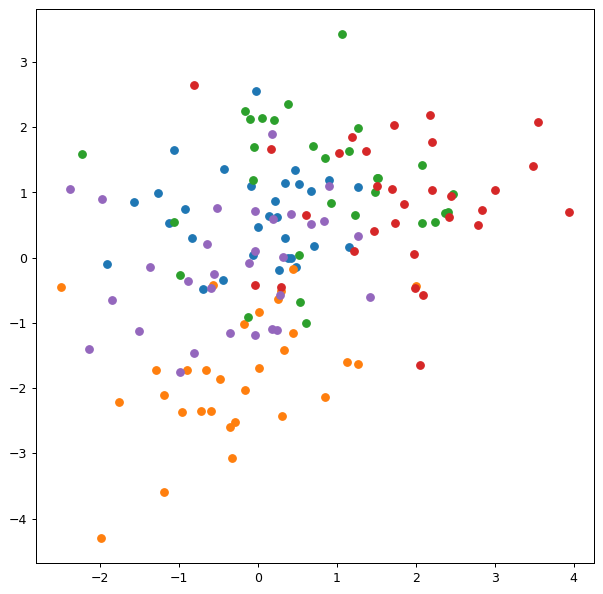

In [85]:
# produce a high-dimensional data set, composed of a few Gaussian point clouds in high-dimensional space

n_dim=100 # a really high-dimensional space

n_clusters=5 # number of clusters, i.e. clouds
N_cluster_points=30 # number of points inside each cluster
N=n_clusters*N_cluster_points # total number of points

Gauss_spread=1.0 # size of each cluster (cloud)

X=np.zeros([N,n_dim])

for j in range(n_clusters):
    Xmean=np.random.randn(n_dim) # the center position of the cluster
    X[j*N_cluster_points:(j+1)*N_cluster_points,:]=Xmean[None,:]+Gauss_spread*np.random.randn(N_cluster_points,n_dim)

# plot these points in a projection into 2D space
# color them according to the cluster they belong to!

plt.figure(figsize=(8,8))
for j in range(n_clusters):
    X0=X[j*N_cluster_points:(j+1)*N_cluster_points,0]
    X1=X[j*N_cluster_points:(j+1)*N_cluster_points,1]    
    plt.scatter(X0,X1)
plt.show()

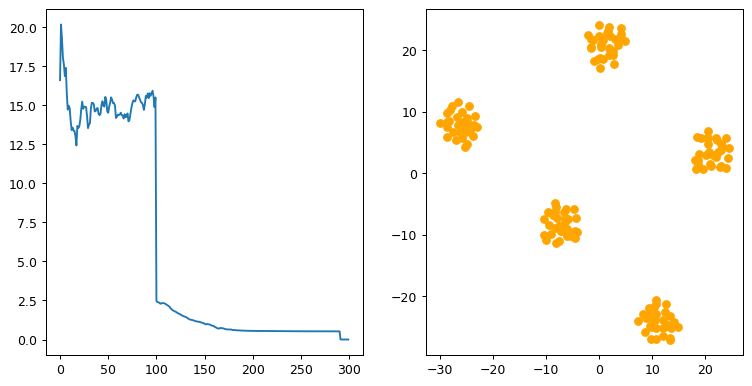

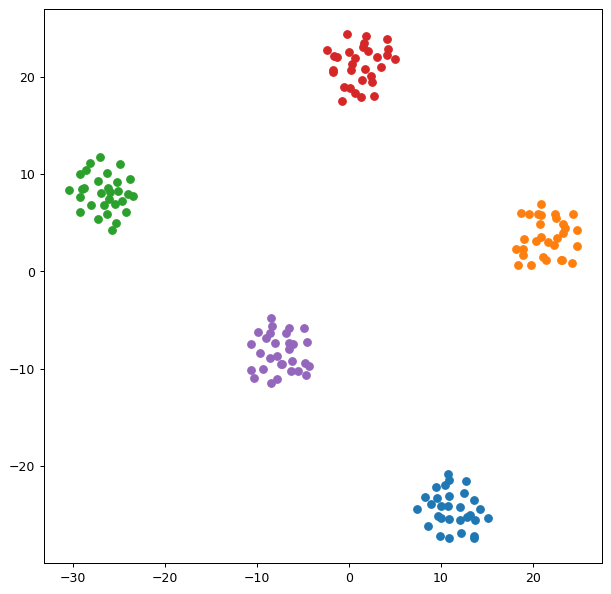

In [86]:
# now apply t-SNE to reduce to two dimensions in a smart way!

Y=tsne(X, no_dims=2, initial_dims=50, perplexity=10.0, 
       do_animation=True, animation_skip_steps=10, max_iter=300)

# plot the points according to the t-SNE projection into 2D space
# color them according to the cluster they belong to!
plt.figure(figsize=(8,8))
for j in range(n_clusters):
    Y0=Y[j*N_cluster_points:(j+1)*N_cluster_points,0]
    Y1=Y[j*N_cluster_points:(j+1)*N_cluster_points,1]    
    plt.scatter(Y0,Y1)
plt.show()

# Example 2: Multiple Gaussians: finding the true number without labels!

In [87]:
# Plot a tSNE-scatterplot, but with some randomly marked points,
# together with the corresponding high-dimensional data points plotted
# as curves!

def plot_tsne_with_curves(y0,y1,x,xlabel,n_picks=10,vmin=-0.1,vmax=2):
    random_picks=np.random.randint(np.shape(y0)[0],size=n_picks) # pick some random points
    
    fig=plt.figure(constrained_layout=True,figsize=(8,4))
    gs=fig.add_gridspec(ncols=8,nrows=4)
    scatter_plot=fig.add_subplot(gs[0:4,0:4])
    
    myplot={}
    j=0
    for n0 in range(4):
        for n1 in range(4):
            myplot[j]=fig.add_subplot(gs[n0,4+n1])
            myplot[j].axis('off')
            j+=1
    
    scatter_plot.scatter(y0,y1,c=xlabel)
    scatter_plot.scatter(y0[random_picks],y1[random_picks],color="black",alpha=0.7,s=80)
    
    for idx in range(len(random_picks)):
        scatter_plot.text(y0[random_picks[idx]], y1[random_picks[idx]], 
                      str(idx), fontsize=8, color="orange", 
                     alpha=0.8, horizontalalignment='center',
                verticalalignment='center')
    
    for idx,m in enumerate(random_picks):
        if idx<j:
            myplot[idx].plot(x[m,:])
            myplot[idx].text(0.1, 0.75, str(idx), fontsize=12, color="orange", 
                             alpha=0.5, horizontalalignment='center',
                        verticalalignment='center', transform=myplot[idx].transAxes)
            myplot[idx].set_ylim([vmin,vmax])
        
    plt.show()

In [88]:
def my_generator1D(batchsize,x): # produce a batch of curves, a random number of Gaussian
    maxNum=2 # the maximum number of Gaussians
    NumGaussians=np.random.randint(maxNum+1,size=batchsize) # select the number, for each sample
    Curves=np.zeros([batchsize,len(x)])
    for j in range(maxNum):
        R=np.random.uniform(low=0.1,high=0.11,size=batchsize) # width
        A=np.random.uniform(low=0.9,high=1.0,size=batchsize) # amplitude
        x0=np.random.uniform(size=batchsize,low=-0.8,high=0.8) # position
        Curves+=(j<=NumGaussians[:,None]-1)*A[:,None]*np.exp(-((x[None,:]-x0[:,None])/R[:,None])**2)
    Curves+=0.1*np.random.randn(batchsize,len(x)) # add a bit of background noise on top
    return( Curves, NumGaussians )

n_dim=100
x=np.linspace(-1,1,n_dim)
N=2000 # how many curves

X,Xlabel=my_generator1D(N,x) 
# small x is the coordinate, capital X are the high-dim. "data points", meaning samples of curves!



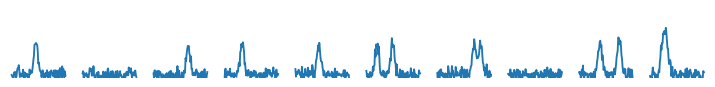

In [89]:
fig,ax=plt.subplots(ncols=10,nrows=1,figsize=(10,1))
for n in range(10):
    ax[n].plot(X[n,:])
    ax[n].set_ylim([-0.1,2])
    ax[n].axis('off')
plt.show()

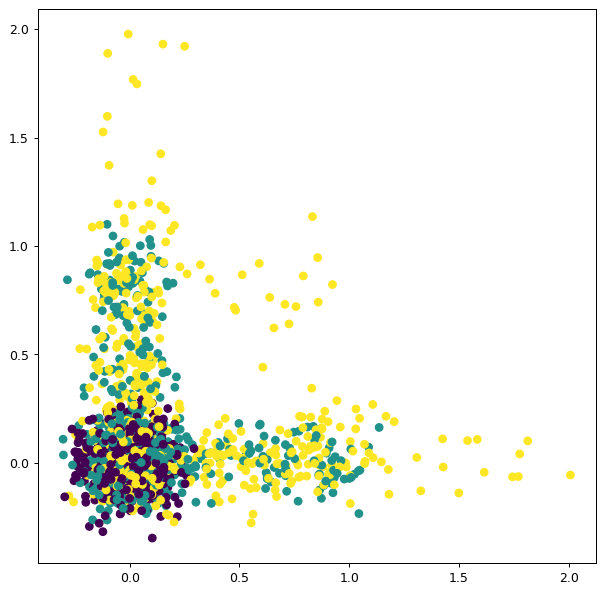

In [90]:
# plot these points in a projection into 2D space

# pick two arbitrary coordinates
j0=17
j1=35

plt.figure(figsize=(8,8))
X0=X[:,j0]
X1=X[:,j1]    
plt.scatter(X0,X1,c=Xlabel)
plt.show()

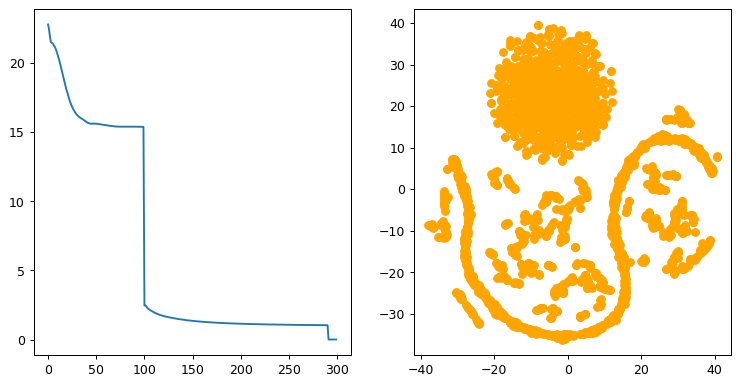

In [91]:
# now apply t-SNE to reduce to two dimensions in a smart way!

Y=tsne(X, 2, 20, 30.0, do_animation=True, animation_skip_steps=10, max_iter=300)

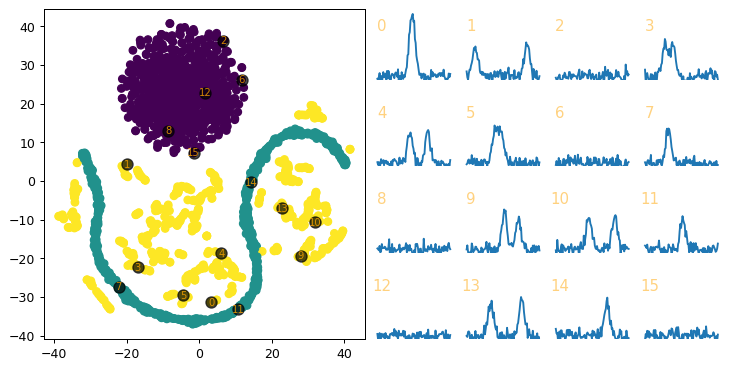

In [92]:
plot_tsne_with_curves(Y[:,0],Y[:,1],X,Xlabel,n_picks=16)

# Tutorial Exercise 1: Change the perplexity parameter in the 'Gaussian cloud' example and/or the 'multiple Gaussians' example and observe its effect!



# Tutorial Exercise 2: Modify the 'multiple Gaussians' example by inventing different sample curves



In [93]:
# Plot a tSNE-scatterplot, but with some randomly marked points,
# together with the corresponding high-dimensional data points plotted
# as curves!

def plot_tsne_with_curves(y0,y1,x,xlabel,n_picks=10,vmin=-0.1,vmax=2):
    random_picks=np.random.randint(np.shape(y0)[0],size=n_picks) # pick some random points
    
    fig=plt.figure(constrained_layout=True,figsize=(8,4))
    gs=fig.add_gridspec(ncols=8,nrows=4)
    scatter_plot=fig.add_subplot(gs[0:4,0:4])
    
    myplot={}
    j=0
    for n0 in range(4):
        for n1 in range(4):
            myplot[j]=fig.add_subplot(gs[n0,4+n1])
            myplot[j].axis('off')
            j+=1
    
    scatter_plot.scatter(y0,y1,c=xlabel)
    scatter_plot.scatter(y0[random_picks],y1[random_picks],color="black",alpha=0.7,s=80)
    
    for idx in range(len(random_picks)):
        scatter_plot.text(y0[random_picks[idx]], y1[random_picks[idx]], 
                      str(idx), fontsize=8, color="orange", 
                     alpha=0.8, horizontalalignment='center',
                verticalalignment='center')
    
    for idx,m in enumerate(random_picks):
        if idx<j:
            myplot[idx].plot(x[m,:])
            myplot[idx].text(0.1, 0.75, str(idx), fontsize=12, color="orange", 
                             alpha=0.5, horizontalalignment='center',
                        verticalalignment='center', transform=myplot[idx].transAxes)
            myplot[idx].set_ylim([vmin,vmax])
        
    plt.show()

In [110]:
def my_generator1D(batchsize,x): # produce a batch of curves, a random number of Gaussian
    maxNum=2 # the maximum number of Gaussians
    NumLorentzian=np.random.randint(maxNum+1,size=batchsize) # select the number, for each sample
    Curves=np.zeros([batchsize,len(x)])
    for j in range(maxNum):
        R=np.random.uniform(low=0.1,high=0.11,size=batchsize) # width
        A=np.random.uniform(low=0.9,high=1.0,size=batchsize) # amplitude
        x0=np.random.uniform(size=batchsize,low=-0.8,high=0.8) # position
        #Curves+=(j<=NumGaussians[:,None]-1)*A[:,None]*np.exp(-((x[None,:]-x0[:,None])/R[:,None])**2)
        Curves+=(j<=NumLorentzian[:,None]-1)*A[:,None]/(((x[None,:]-x0[:,None])/R[:,None])**2+1)
    Curves+=0.1*np.random.randn(batchsize,len(x)) # add a bit of background noise on top
    return( Curves, NumLorentzian )

n_dim=100
x=np.linspace(-1,1,n_dim)
N=2000 # how many curves

X,Xlabel=my_generator1D(N,x) 
# small x is the coordinate, capital X are the high-dim. "data points", meaning samples of curves!


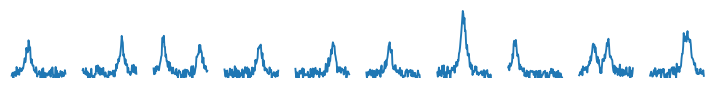

In [95]:
fig,ax=plt.subplots(ncols=10,nrows=1,figsize=(10,1))
for n in range(10):
    ax[n].plot(X[n,:])
    ax[n].set_ylim([-0.1,2])
    ax[n].axis('off')
plt.show()

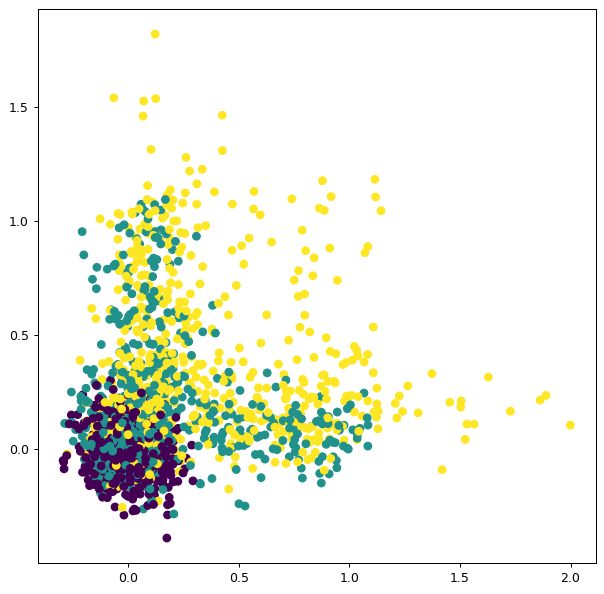

In [109]:
# plot these points in a projection into 2D space

# pick two arbitrary coordinates
j0=17
j1=35

plt.figure(figsize=(8,8))
X0=X[:,j0]
X1=X[:,j1]    
plt.scatter(X0,X1,c=Xlabel)
plt.show()

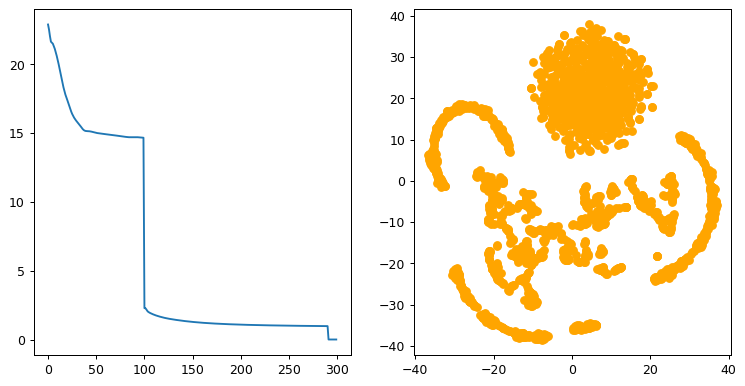

In [30]:
# now apply t-SNE to reduce to two dimensions in a smart way!

Y=tsne(X, 2, 20, 30.0, do_animation=True, animation_skip_steps=10, max_iter=300)

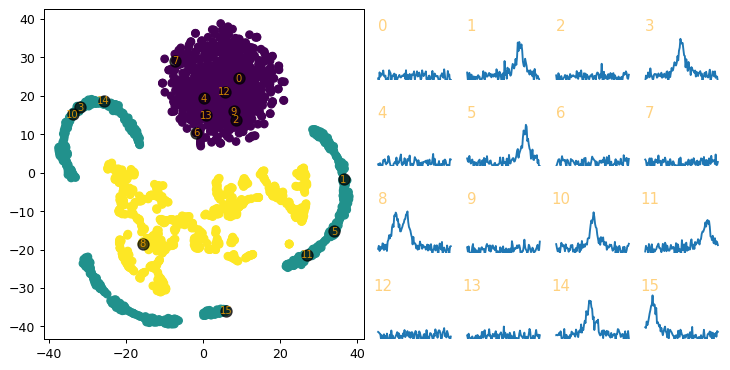

In [31]:
plot_tsne_with_curves(Y[:,0],Y[:,1],X,Xlabel,n_picks=16)

 *(1) Train an autoencoder and then visualize the neuron activations in the bottleneck layer via t-SNE! (i.e. for each of many input images extract the bottleneck activations, which defines a vector in a high-dimensional space. Plot all these vectors in a 2D projection produced by t-SNE) Can you observe any meaningful clusters?



In [10]:
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, UpSampling2D


In [11]:
# produce random circles with noise, returning also circles without noise

def my_generator2D(batchsize,x,y):
    R=np.random.uniform(low=0.2,high=1,size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-0.8,high=0.8)
    y0=np.random.uniform(size=batchsize,low=-0.8,high=0.8)
    noise_stddev = 0.2
    noise = np.random.normal(loc=0, scale=noise_stddev, size=(batchsize, len(X), len(Y)))
    v_batches = np.ones(batchsize)
    Circles=1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2)
    inputLayer = v_batches[:, None, None]*Circles + noise
    resultLayer= v_batches[:, None, None]*Circles
    return( inputLayer, resultLayer  )



In [12]:
N=27 # number of pixels in 'image'

# Net=Sequential()
# # 3x3 kernel size, 10 channels in first hidden layer:
# Net.add(Conv2D(3,10,input_shape=(None,None,1),
#                activation="relu",padding='same'))
# # 3x3 kernel size, only 1 channel in last hidden layer:
# Net.add(Conv2D(1,3,activation="relu",padding='same'))
# Net.compile(loss='mean_squared_error',
#               optimizer='adam',
#             metrics='accuracy')
Net=Sequential()
# 3x3 kernel size, 4 channels in first hidden layer:
Net.add(Conv2D(4,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
Net.add(AveragePooling2D(pool_size=(3,3),padding='same')) # down
Net.add(Conv2D(4,5,
               activation="relu",padding='same'))
Net.add(AveragePooling2D(pool_size=(3,3),padding='same')) # down
Net.add(Conv2D(1,3,
               activation="relu",padding='same'))
Net.add(UpSampling2D(size=(3,3))) # up
Net.add(Conv2D(4,5,
               activation="relu",padding='same'))
Net.add(UpSampling2D(size=(3,3))) # up
Net.add(Conv2D(4,5,
               activation="relu",padding='same'))
Net.add(Conv2D(1,3,activation="linear",padding='same'))
Net.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics='accuracy')


2023-06-12 17:12:02.360596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
Net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 4)     104       
                                                                 
 average_pooling2d (AverageP  (None, None, None, 4)    0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 4)     404       
                                                                 
 average_pooling2d_1 (Averag  (None, None, None, 4)    0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 1)     37        
                                                                 
 up_sampling2d (UpSampling2D  (None, None, None, 1)    0

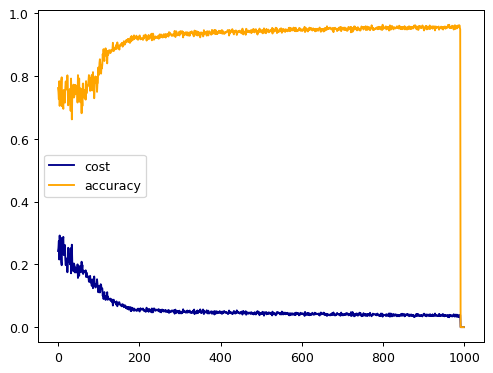

In [14]:
batchsize=30
steps=200

vals=np.linspace(-1,1,N)
X,Y=np.meshgrid(vals,vals)
#x,y=X.flatten(),Y.flatten() # make 1D arrays, as needed for dense layers!

costs=np.zeros(steps)
accuracy=np.zeros(steps)
skipsteps=10

for j in range(steps):
    y_in,y_target=my_generator2D(batchsize,X,Y)
    costs[j],accuracy[j]=Net.train_on_batch(y_in,y_target)
    if j%skipsteps==0:
        clear_output(wait=True)
        plt.plot(costs,color="darkblue",label="cost")
        plt.plot(accuracy,color="orange",label="accuracy")
        plt.legend()
        plt.show()

In [15]:
y_in,y_target=my_generator2D(batchsize,X,Y)
y_pred=Net.predict_on_batch(y_in)


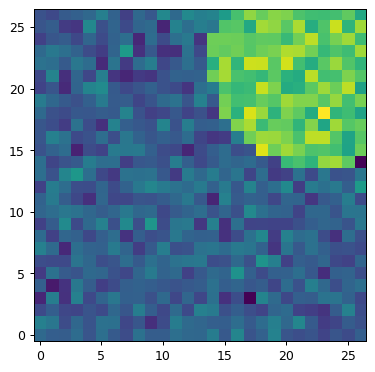

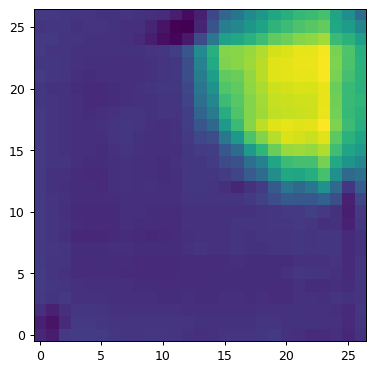

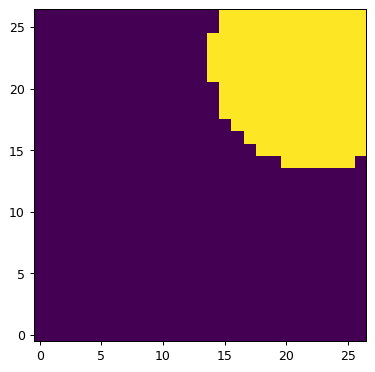

In [16]:
index_plotting = 10
plt.imshow(np.reshape(y_in[index_plotting,:,:],[N,N]),origin='lower')
plt.figure()
plt.imshow(np.reshape(y_pred[index_plotting,:,:],[N,N]),origin='lower')
plt.figure()
plt.imshow(np.reshape(y_target[index_plotting,:,:],[N,N]),origin='lower')

In [53]:
#for layer in Net.layers: print(layer.get_config())
A = np.zeros(len(bottleneck_layer_weights))

In [54]:
bottleneck_layer_weights = Net.layers[4].get_weights()[0].flatten()
np.shape(bottleneck_layer_weights)

(36,)

In [55]:
A = np.vstack([A, bottleneck_layer_weights])


In [56]:
np.shape(bottleneck_layer_weights.flatten())

(36,)

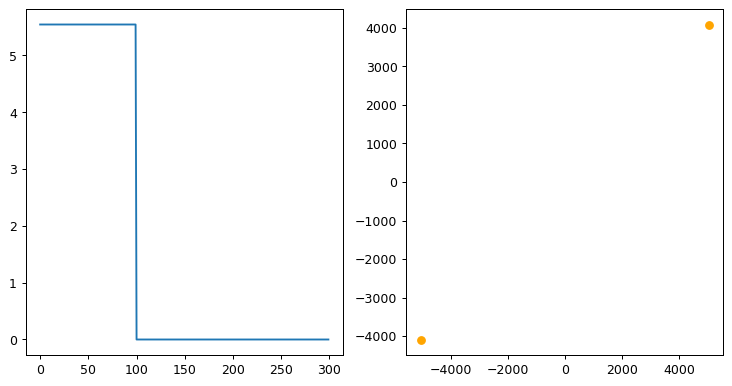

In [58]:
# now apply t-SNE to reduce to two dimensions in a smart way!

Y=tsne(A, no_dims=2, initial_dims=36, perplexity=3.0, 
       do_animation=True, animation_skip_steps=10, max_iter=300)


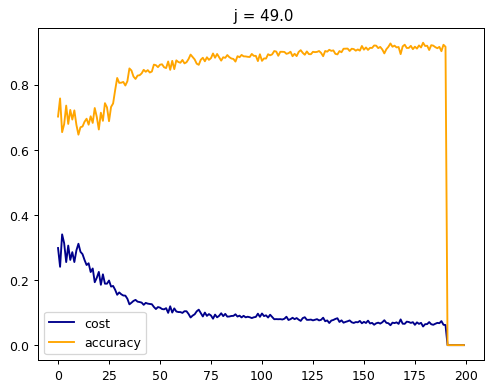

In [76]:
N = 50
A = np.zeros((N,36))

for jj in range(N):
    N=27 # number of pixels in 'image'

    # Net=Sequential()
    # # 3x3 kernel size, 10 channels in first hidden layer:
    # Net.add(Conv2D(3,10,input_shape=(None,None,1),
    #                activation="relu",padding='same'))
    # # 3x3 kernel size, only 1 channel in last hidden layer:
    # Net.add(Conv2D(1,3,activation="relu",padding='same'))
    # Net.compile(loss='mean_squared_error',
    #               optimizer='adam',
    #             metrics='accuracy')
    Net=Sequential()
    # 3x3 kernel size, 4 channels in first hidden layer:
    Net.add(Conv2D(4,5,input_shape=(None,None,1),
                activation="relu",padding='same'))
    Net.add(AveragePooling2D(pool_size=(3,3),padding='same')) # down
    Net.add(Conv2D(4,5,
                activation="relu",padding='same'))
    Net.add(AveragePooling2D(pool_size=(3,3),padding='same')) # down
    Net.add(Conv2D(1,3,
                activation="relu",padding='same'))
    Net.add(UpSampling2D(size=(3,3))) # up
    Net.add(Conv2D(4,5,
                activation="relu",padding='same'))
    Net.add(UpSampling2D(size=(3,3))) # up
    Net.add(Conv2D(4,5,
                activation="relu",padding='same'))
    Net.add(Conv2D(1,3,activation="linear",padding='same'))
    Net.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics='accuracy')
    batchsize=30
    steps=200

    vals=np.linspace(-1,1,N)
    X,Y=np.meshgrid(vals,vals)
    #x,y=X.flatten(),Y.flatten() # make 1D arrays, as needed for dense layers!

    costs=np.zeros(steps)
    accuracy=np.zeros(steps)
    skipsteps=10
    # produce random circles with noise, returning also circles without noise

    

    if jj%2 == 0:
        def my_generator2D(batchsize,x,y):
            R=np.random.uniform(low=0.2,high=1,size=batchsize)
            x0=np.random.uniform(size=batchsize,low=-0.8,high=0.8)
            y0=np.random.uniform(size=batchsize,low=-0.8,high=0.8)
            noise_stddev = 0.2
            noise = np.random.normal(loc=0, scale=noise_stddev, size=(batchsize, len(X), len(Y)))
            v_batches = np.ones(batchsize)
            Circles=1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2)
            inputLayer = v_batches[:, None, None]*Circles + noise
            resultLayer= v_batches[:, None, None]*Circles
            return( inputLayer, resultLayer  )
    else:
        def my_generator2D(batchsize,x,y):
            R=np.random.uniform(low=0.2,high=1,size=batchsize)
            x0=np.random.uniform(size=batchsize,low=-0.8,high=0.8)
            y0=np.random.uniform(size=batchsize,low=-0.8,high=0.8)
            noise_stddev = 0.2
            noise = np.random.normal(loc=0, scale=noise_stddev, size=(batchsize, len(X), len(Y)))
            v_batches = np.ones(batchsize)
            Squares=1.0*(np.abs(x[None,:,:]-x0[:,None, None])<R[:,None, None])*(np.abs(y[None,:,:]-y0[:,None,None])<R[:,None,None])
            inputLayer = v_batches[:, None, None]*Squares + noise
            resultLayer= v_batches[:, None, None]*Squares
            return( inputLayer, resultLayer  )
    for j in range(steps):       
        
        y_in,y_target=my_generator2D(batchsize,X,Y)
        costs[j],accuracy[j]=Net.train_on_batch(y_in,y_target)
        if j%skipsteps==0:
            clear_output(wait=True)
            plt.title(f" j = {jj:.1f}")
            plt.plot(costs,color="darkblue",label="cost")
            plt.plot(accuracy,color="orange",label="accuracy")
            plt.legend()
            plt.show()
    bottleneck_layer_weights = Net.layers[4].get_weights()[0].flatten()

    A[jj, : ] = bottleneck_layer_weights

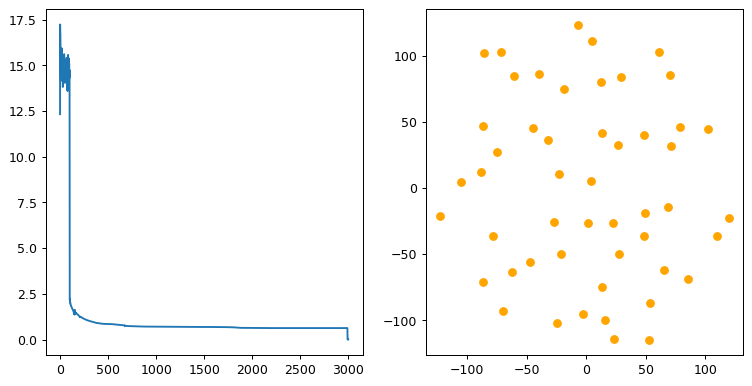

In [113]:
# now apply t-SNE to reduce to two dimensions in a smart way!

Y=tsne(A, no_dims=2, initial_dims=36, perplexity=10.0, 
       do_animation=True, animation_skip_steps=10, max_iter=3000)


ValueError: 'c' argument has 2000 elements, which is inconsistent with 'x' and 'y' with size 50.

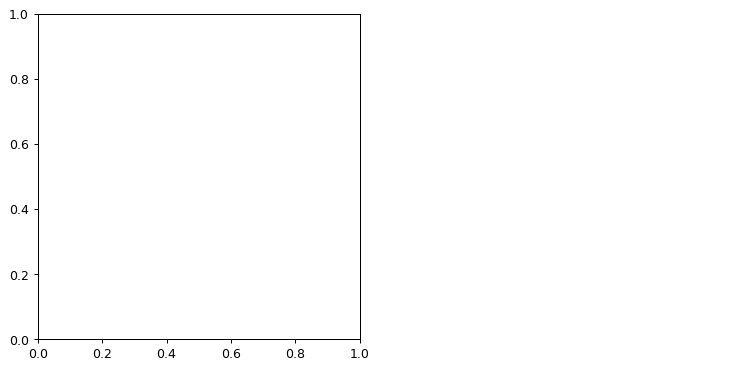

In [104]:
plot_tsne_with_curves(A[:,0:2:50],A[:,1:2:50],X,Xlabel,n_picks=16)

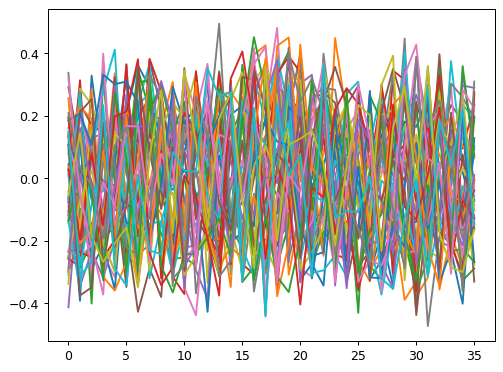

In [82]:
plt.plot(np.transpose(A))

# T-sne on MNIST images weights

In [114]:
# Import keras library. Also import some of the layers, so we do not need to
# write things like "layers.Dense", but can just write "Dense" instead
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GaussianDropout
import tensorflow.keras.optimizers as optimizers

# Import the numpy library for matrix manipulations etc.

#from numpy import *
from numpy import array, zeros, exp, random, dot, shape, transpose, reshape, meshgrid, linspace, sqrt, sum, argmax, where

# Set up the graphics by importing the matplotlib plotting library
import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=90 # highres display

# Set up a random number generator with a fixed seed, so that
# running this whole notebook repeatedly should always give
# the same result (useful for debugging)
rng = random.RandomState(23455)

import time

In [115]:
"""
mnist_loader
~~~~~~~~~~~~

taken from Nielsen's online book:
http://neuralnetworksanddeeplearning.com/chap1.html


A library to load the MNIST image data.  For details of the data
structures that are returned, see the doc strings for ``load_data``
and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the
function usually called by our neural network code.
"""

#### Libraries
# Standard library
import pickle
import gzip

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f,encoding='bytes')
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.

    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    
    global training_inputs, training_results
    global validation_inputs, validation_results
    global test_inputs, test_results
    global num_samples, numpixels, num_test_samples
    
    tr_d, va_d, te_d = load_data()
    
    num_samples=len(tr_d[0])
    training_inputs=zeros([num_samples,numpixels])
    training_results=zeros([num_samples,10])    
    for j in range(num_samples):
        training_inputs[j,:] = reshape(tr_d[0][j], (numpixels))
        training_results[j,:] = vectorized_result(tr_d[1][j])
#    validation_inputs = [reshape(x, (numpixels)) for x in va_d[0]]
#    validation_results = [vectorized_result(y) for y in va_d[1]]

    num_test_samples=len(te_d[0])
    test_inputs=zeros([num_test_samples,numpixels])
    test_results=zeros([num_test_samples,10])    
    for j in range(num_test_samples):
        test_inputs[j,:] = reshape(te_d[0][j], (numpixels))
        test_results[j,:] = vectorized_result(te_d[1][j])

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = zeros((10))
    e[j] = 1.0
    return e

In [116]:
# initialize the network
def init_net():
    global net, numpixels
    net = Sequential()
    # note: batch_input_shape is (batchsize,timesteps,data_dim)
    net.add(Dense(30, input_shape=(numpixels,), activation='relu'))
    net.add(Dense(10, activation='softmax'))
    net.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1.0), metrics=['categorical_accuracy'])

In [117]:
# initialize the network
def init_net_large():
    global net, numpixels
    net = Sequential()
    # note: batch_input_shape is (batchsize,timesteps,data_dim)
    net.add(Dense(100, input_shape=(numpixels,), activation='relu'))
    net.add(GaussianDropout(0.1))
    net.add(Dense(50, activation='relu'))
    net.add(Dense(10, activation='softmax'))
    net.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1.0), metrics=['categorical_accuracy'])

In [118]:
def test_on(start,stop,dontprint=False):
    global test_inputs, test_results
    global net, predictions_probs, predictions, true_labels
    
    predictions_probs=net.predict_on_batch(test_inputs[start:stop,:])
    predictions=argmax(predictions_probs,axis=1)
    if dontprint==False:
        print("Predictions: ", predictions)
    true_labels=argmax(test_results[start:stop,:], axis=1)
    if dontprint==False:
        print("True labels: ", true_labels)

In [119]:
def display_image(which):
    global test_inputs
    
    plt.imshow(reshape(test_inputs[which,:],[28,28]),interpolation='nearest', cmap='binary')
    plt.show()

In [120]:
def display_image_array(which):
    global test_inputs
    
    numcolumns=8
    BigImage=zeros([28*numcolumns,28*numcolumns])
    for j in range(len(which)):
        x=(j%numcolumns)*28
        y=int(j/numcolumns)*28
        BigImage[x:x+28,y:y+28]=reshape(test_inputs[which[j],:],[28,28])
    plt.imshow(BigImage,interpolation='nearest', cmap='binary')
    plt.show()

In [121]:
def display_mistakes(maxnum):
    global test_inputs, rest_results, num_test_samples
    global true_labels, predictions, predictions_probs
    
    test_on(0,num_test_samples,dontprint=True)
    which=where(true_labels!=predictions)[0]
    for j in which:
        if j<maxnum:
            display_image(j)
            print("True ", true_labels[j], " - Predicted ", predictions[j], " with prob. ", predictions_probs[j,predictions[j]])
        

## Test out things

In [122]:
numpixels=784
load_data_wrapper() # load all the MNIST images

In [123]:
shape(training_inputs)

(50000, 784)

In [124]:
psi=training_inputs-sum(training_inputs,axis=0)/num_samples

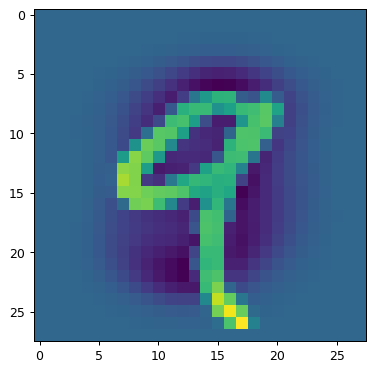

In [125]:
plt.imshow(reshape(psi[4,:],[28,28]))

In [126]:
shape(psi)

(50000, 784)

In [ ]:
shape(training_inputs)

(50000, 784)

In [131]:
np.sqrt(numpixels)

28.0

In [197]:
N=28 # number of pixels in 'image'

# Net=Sequential()
# # 3x3 kernel size, 10 channels in first hidden layer:
# Net.add(Conv2D(3,10,input_shape=(None,None,1),
#                activation="relu",padding='same'))
# # 3x3 kernel size, only 1 channel in last hidden layer:
# Net.add(Conv2D(1,3,activation="relu",padding='same'))
# Net.compile(loss='mean_squared_error',
#               optimizer='adam',
#             metrics='accuracy')
Net=Sequential()
# 3x3 kernel size, 4 channels in first hidden layer:
Net.add(Conv2D(4,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
Net.add(AveragePooling2D(pool_size=(2,2),padding='same')) # down
Net.add(Conv2D(4,5,
               activation="relu",padding='same'))
Net.add(AveragePooling2D(pool_size=(2,2),padding='same')) # down
Net.add(Conv2D(1,5,
               activation="relu",padding='same'))
Net.add(UpSampling2D(size=(2,2))) # up
Net.add(Conv2D(4,5,
               activation="relu",padding='same'))
Net.add(UpSampling2D(size=(2,2))) # up
Net.add(Conv2D(4,5,
               activation="relu",padding='same'))
Net.add(Conv2D(1,4,activation="linear",padding='same'))
Net.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics='accuracy')


In [195]:
np.shape(psi_reshaped[j,:,:])

(28, 28)

In [199]:

psi_reshaped = np.reshape(psi, [50000,N,N])
batchsize=3
batches=int(num_samples/batchsize)-1
costs=zeros(batches)

N_epoches = 2
save_weights = np.zeros((N,36))
A = np.zeros((N_epoches,36))

for j in range(batches):
    for ii in range(N_epoches):
        costs[j]=Net.train_on_batch(psi_reshaped[j*batchsize:(j+1)*batchsize,:], psi_reshaped[j*batchsize:(j+1)*batchsize,:])
    bottleneck_layer_weights = Net.layers[4].get_weights()[0].flatten()
    A[ii, : ] = bottleneck_layer_weights
plt.plot(costs,linewidth=3)
plt.show()

ValueError: setting an array element with a sequence.

In [ ]:
out = Net.predict_on_batch(psi_reshaped[j*batchsize:(j+1)*batchsize,:])

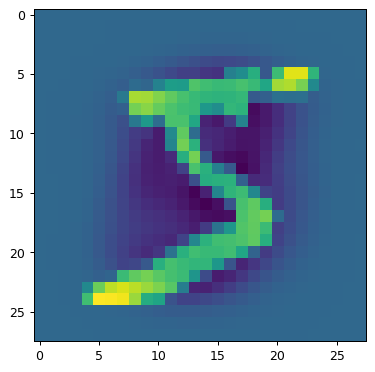

In [183]:
plt.imshow(psi_reshaped[0,:,:])

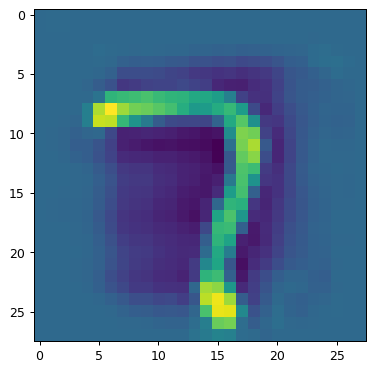

In [184]:
plt.imshow(out[0,:,:])

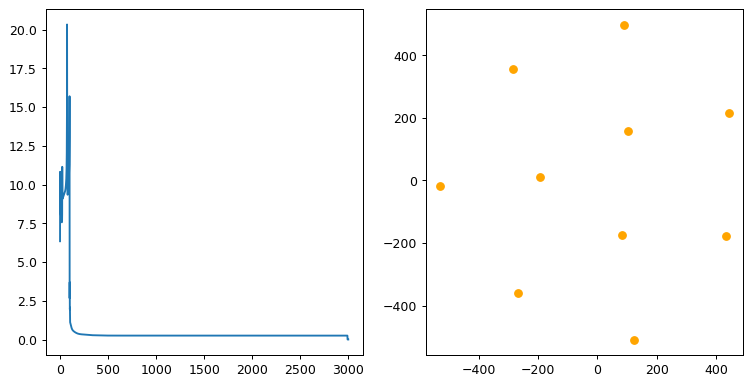

In [172]:
# now apply t-SNE to reduce to two dimensions in a smart way!

Y=tsne(A, no_dims=2, initial_dims=36, perplexity=10.0, 
       do_animation=True, animation_skip_steps=10, max_iter=3000)
